# Imports and Reading Data

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import pandas as pd
import numpy as np

import nltk
import re

from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Downloading all the requirements
!pip install scikit-multilearn
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

!pip install contractions
import contractions

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.metrics import roc_auc_score
from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Setting global parameters for the Plots
rcParams['figure.figsize'] = 18, 9 
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'smaller'
rcParams['ytick.labelsize'] = 'smaller'
rcParams['axes.labelpad'] = 15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
# Read the data
df_train = pd.read_csv("drive/MyDrive/MLProject/train.csv")
df_test = pd.read_csv("drive/MyDrive/MLProject/test.csv")

# Preprocessing

In [66]:
# Check the first five rows of our dataset
df_train.head()

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,a8be7c5d4527adbbf15f,""", 6 December 2007 (UTC)\nI am interested, not...",0,0,0,0,0,0
1,0b7ca73f388222aad64d,I added about three missing parameters to temp...,0,0,0,0,0,0
2,db934381501872ba6f38,SANDBOX?? \n\nI DID YOUR MADRE DID IN THE SANDBOX,1,0,0,0,0,0
3,228015c4a87c4b1f09a7,"why good sir? Why? \n\nYou, sir, obviously do ...",1,0,1,1,1,0
4,b18f26cfa1408b52e949,"""\n\n Source \n\nIncase I forget, or someone e...",0,0,0,0,0,0


In [67]:
#check the first element of the text column
df_train['text'].iloc[0]

'", 6 December 2007 (UTC)\nI am interested, not in arguing, but in the policies which resolve our ongoing content dispute. Also, see Wikipedia: WikiProject United States presidential elections for what I\'ll be working on. Also, the moneybomb closer just self-reverted on two different requests, which echoed what I would have requested.  I will rephrase #3, which I didn\'t see an answer to, building on our agreement that ""moneybomb"" should not be a redlink: Given the deletion reversion, what should be the outline of the article called ""moneybomb"" or should it be submitted for AFD again in due time? (If the latter, see the previous version of #3.) However, this version will require a detailed answer because any ambiguity will only necessitate clarifying questions.   22:32"'

In [68]:
#let us check the count, mean, std and other params of the data
df_train.describe()

,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
count,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000
mean,0.095782,0.010262,0.053067,0.002999,0.049150,0.008975
std,0.294294,0.100781,0.224168,0.054683,0.216182,0.094311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
# df_train.loc[df_train['text'].str.contains(':\)')]

### Basic text preprocessing





1.   Remove URLs, HTML Tags, Non-Alphanumeric characters, extra whitespaces, lowercase
2.   Lemmatize
3.   Remove Stopwords
4.   Remove words with length <= 2
5.   Fix Contractions

In [70]:
class preprocess:

    def __init__(self):
        pass

    def clean(self, df, column):
      
        # applying all the methods in sequence
        df[column] = df[column].apply(self.rm_decontracted)
        df[column] = df[column].apply(self.rm_urls)
        df[column] = df[column].apply(self.rm_html_tags)
        df[column] = df[column].apply(self.rm_non_alpha)
        df[column] = self.rm_stopwords(df, column)
        # df[column] = self.fix_contractions(df, column)
        df[column] = df[column].apply(self.rm_patterns_removal)
        df[column] = df[column].apply(self.rm_numword_removal)
        df[column] = self.rm_whitespace(df, column)

        # lowercasing the text
        df[column] = df[column].str.lower()

        df = self.lemmatization(df, column)
        # df[column] = self.rm_stopwords(df, column)
        # df = self.remove_less_2(df, column)
    
        return df

    def rm_urls(self, text):
        return re.sub(r'http\S+', ' ', text)
    
    def rm_html_tags(self, text):
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)

    def rm_non_alpha(self, text):
        return re.sub('[^a-zA-Z]', ' ', text)

    def rm_whitespace(self, df, column):
        return df[column].apply(lambda x : " ".join(x.split()))

    def lemmatization(self, df, column):
        lemma = WordNetLemmatizer()

        # Lemmatizing with respect to the verb form and noun form
        df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='n') for w in x.split(" ")]))
        df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='v') for w in x.split(" ")]))

        return df

    def rm_stopwords(self, df, column):

        # Generating all the stop words of english and removing no,not nor as they are significantly important
        stop = stopwords.words('english')
        not_stop_words = {'no', 'not', 'nor','very','but'}
        modified_stop = [ele for ele in stop if ele not in not_stop_words]

        return df[column].apply(lambda x : ' '.join([word for word in x.split(' ') if word not in modified_stop]))

    # As the words with less than length 2 will not contribute to toxicity in a general manner
    def _clean_small(self, text):
        return re.sub(r'\b\w{1,2}\b', '', text)

    # After every re.sub we get varied amount of whitespaces so it is essential to remove white spaces
    def remove_less_2(self, df, column):
        df[column] = df[column].apply(self._clean_small)
        df[column] = self.rm_whitespace(df, column)
        return df

    # zzzzzzzzzz remover
    def rm_patterns_removal(self,text): 
        return re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',text)

    #function to remove words with numbers
    def rm_numword_removal(self,text):
        return re.sub("\S*\d\S*", " ", text).strip()

    def rm_decontracted(self,text):
      phrase = re.sub(r"\'t", " not", text)
      phrase = re.sub(r"\'re", " are", phrase)
      phrase = re.sub(r"\'s", " is", phrase)
      phrase = re.sub(r"\'d", " would", phrase)
      phrase = re.sub(r"\'ll", " will", phrase)
      phrase = re.sub(r"\'ve", " have", phrase)
      phrase = re.sub(r"\'m", " am", phrase)
      return phrase

    # def fix_contractions(self, df, column):
    #     return df[column].apply(contractions.fix)
      

In [71]:
df_train = preprocess().clean(df_train, 'text')
df_test = preprocess().clean(df_test, 'text')

In [72]:
df_train['text'].iloc[0]

'december utc i interest not argue but policy resolve ongoing content dispute also see wikipedia wikiproject unite state presidential election i work also moneybomb closer self revert two different request echo i would request i rephrase i see answer build agreement moneybomb not redlink give deletion reversion outline article call moneybomb submit afd due time if latter see previous version however version require detail answer ambiguity necessitate clarify question'

# EDA (Exploratory Data Analysis)

### Count of comments per category

To get a better sense of our MultiLabel Classification we would start by plotting the number of texts in each category.

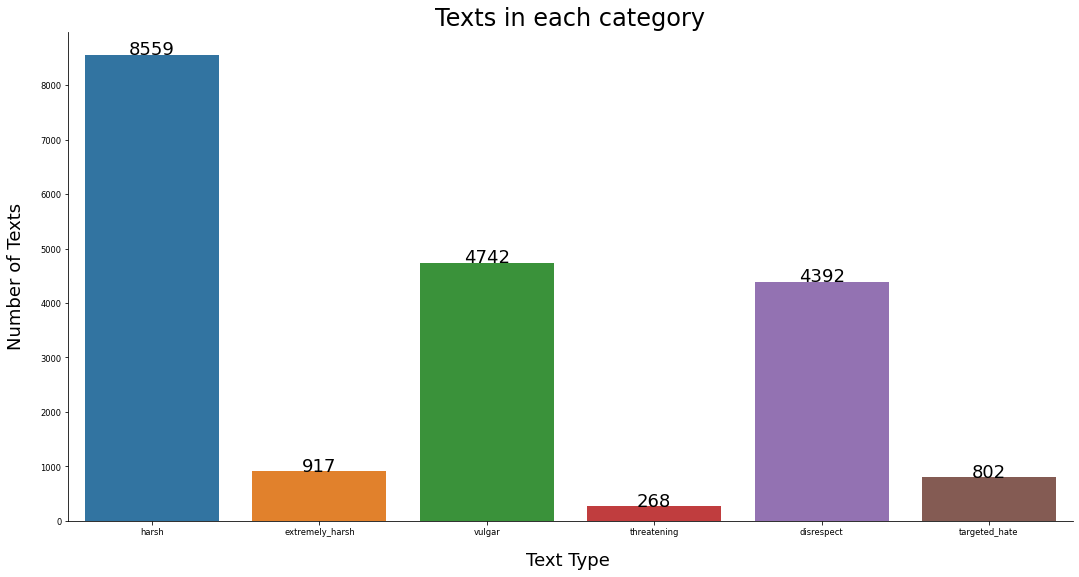

In [73]:
# List all the target columns
categories = list(df_train.columns.values)
categories.remove('id')
categories.remove('text')

#Plot
ax = sns.barplot(x=categories, y=df_train.iloc[:, 2:].sum().values)

#Labelling
plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=18)

#For accessing the subplots in the graph
rects = ax.patches

category_values = df_train.iloc[:, 2:].sum().values

#For each subplot we need to assign a x coordinate, y coordinate and label with the orientation and fontsize
for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)

plt.show()

**Observation**: Our dataset has severe class imbalance. Most conventional classification algorithms perform badly on imbalanced datasets.

### Count of comments with multiple labels

Now let us count the number of comments having multiple labels.

In [74]:
# Finding the rows which correspond to the toxic comments by looking at the toxic column's values.
df_toxic = df_train[(df_train[['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']] > 0).any(axis=1)]
len(df_toxic)

9076

There are only 9076 "Toxic comments" out of 89,359 total comments.

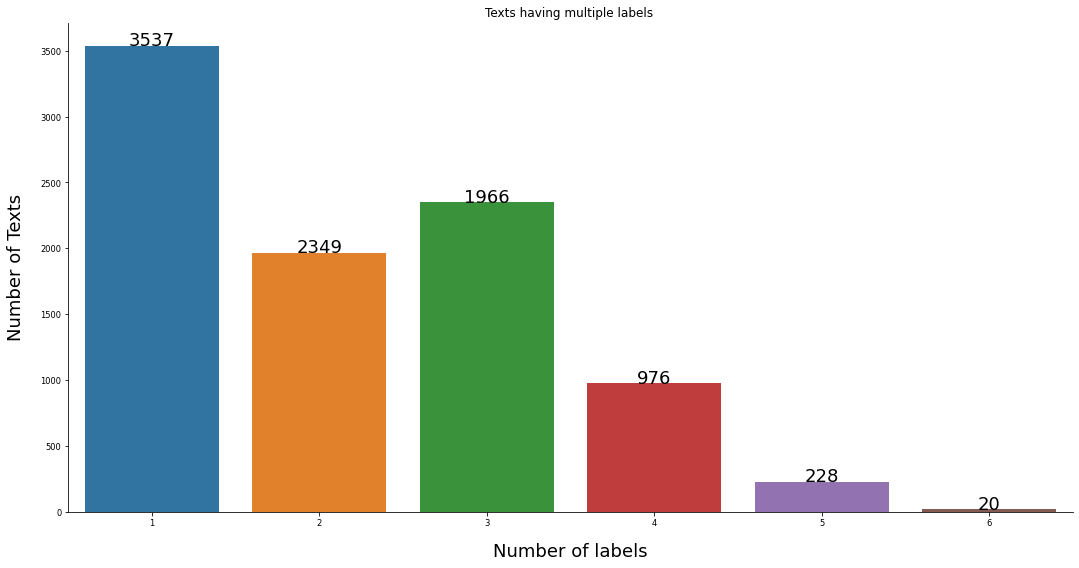

In [75]:
#Sums of the toxic columns for each row
rowSums = df_train.iloc[:, 2:].sum(axis=1)

# corresponding value counts for number of toxic labels
multiLabel_counts = rowSums.value_counts()

#Taking all the non-zero aka toxic comments counts only
multiLabel_counts = multiLabel_counts.iloc[1:]

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Texts having multiple labels ")
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# adding the text labels
rects = ax.patches
category_values = multiLabel_counts.values

for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)
            
plt.show()

**Observations**: All 6 labels at the same time is extremely rare and only one label takes up the majority.

### Top words

Now, let us find the top 100 words by frequency (for toxic comments only)

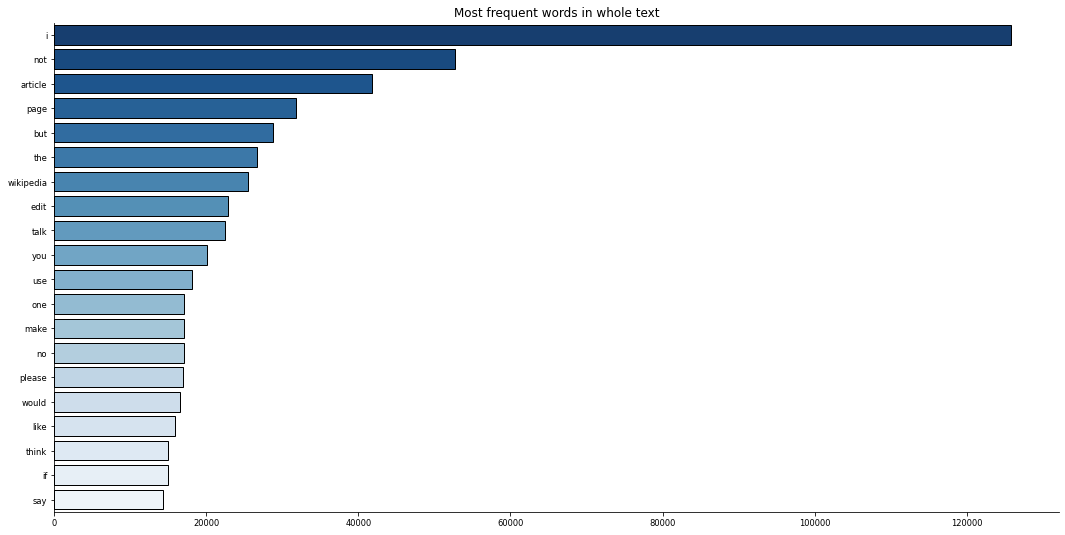

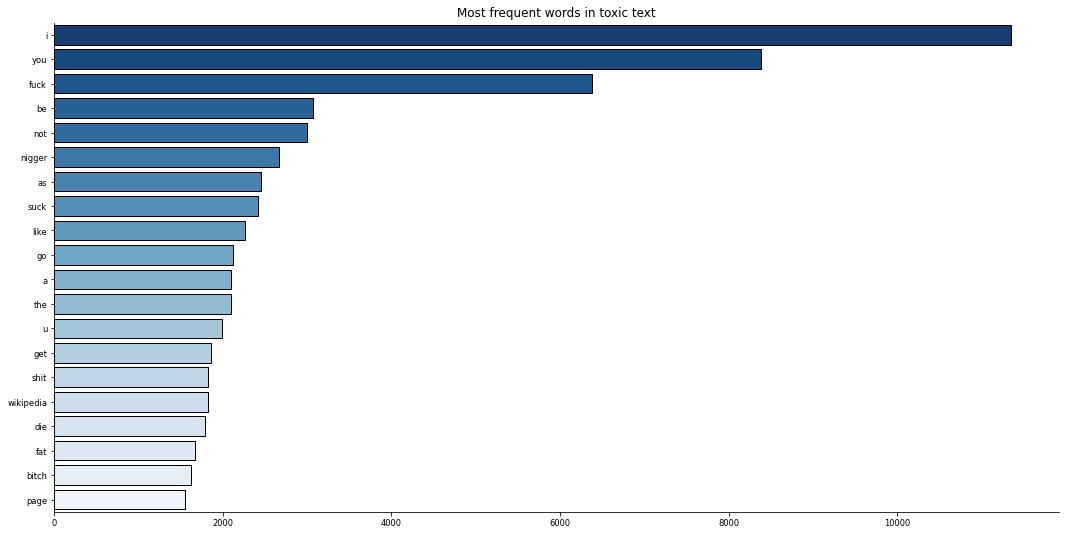

In [76]:
# value counts of each word in all the sentences.
list_words = pd.Series(' '.join(df_train.text).lower().split()).value_counts()
toxic_words = pd.Series(' '.join(df_toxic.text).lower().split()).value_counts()

sns.barplot(y=list_words.iloc[:20].index, x=list_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in whole text")
plt.show()

ax = sns.barplot(y=toxic_words.iloc[:20].index, x=toxic_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in toxic text")
plt.show()

**Observation**: "Clean" words are more frequent than "Toxic" words. This was expected because only about 10% comments are toxic.

### Wordcloud

Let us make a WordCloud to better understand the occurrences of the words which constitute in the majority.

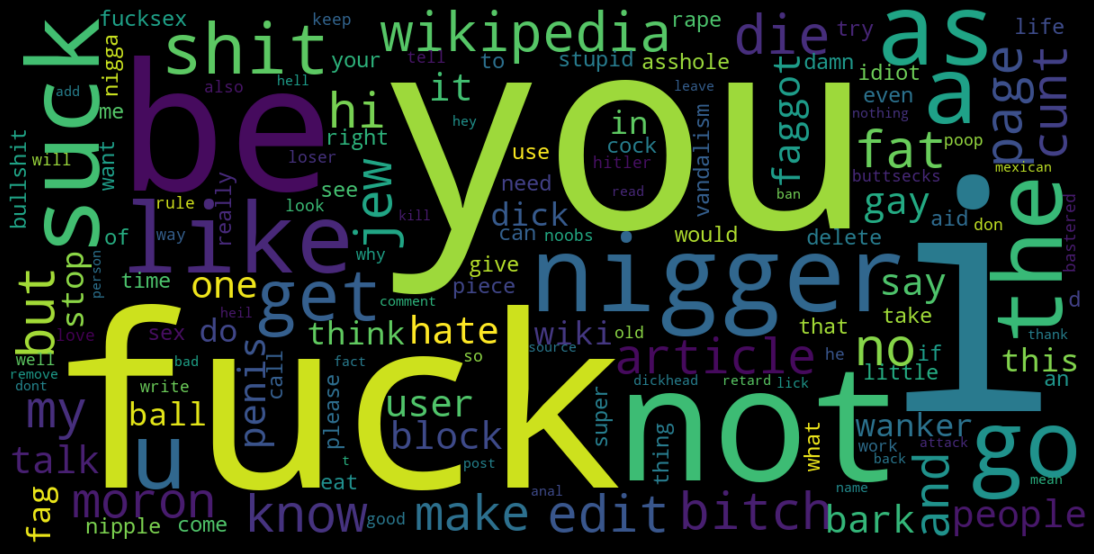

In [77]:
def generate_word_cloud(text):
    wordcloud = WordCloud(background_color = 'black', scale=3, max_words=150).generate_from_frequencies(text)

    fig = plt.figure(figsize = (15, 15), facecolor = 'black', edgecolor = 'black')
    
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_word_cloud(toxic_words)

### Length of Comments

Next, we will plot the length of comments. We can observe that most comments are less than 100 words long.

Text(0, 0.5, 'Count of Comments')

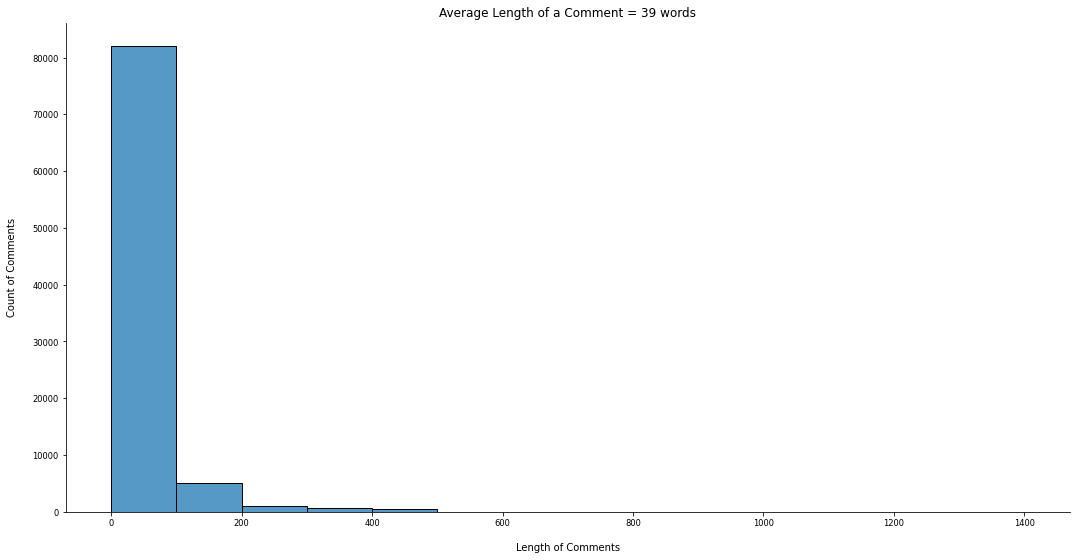

In [78]:
text_len = df_train.text.str.split().str.len()

plt.title("Average Length of a Comment = " + str(int(text_len.mean())) + " words")
# plt.xticks(range(0, 5000+1, 500))

ax = sns.histplot(text_len, binwidth=100)
ax.set_xlabel('Length of Comments')
ax.set_ylabel('Count of Comments')

# Train-Test Split

In [79]:
# For training full train data

# X_train = df_train['text'].to_numpy()
# Y_train = df_train.drop(columns=["id", "text"]).to_numpy()
# X_test = df_test['text'].to_numpy()

In [86]:
# For testing purposes, split training data into train and test
# Here we are using iterative_train_test_split for stratified multi-label split

Y = df_train.drop(columns=["id", "text"]).to_numpy()
X = df_train.iloc[:, :2].to_numpy()
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.1)
X_train = X_train[:, 1]
X_test = X_test[:, 1]

# Model Selection and Training

## OneVsRest

In [81]:
# pipeline for Logisic Regression
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(binary=True, max_features=30000)), 
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=-1)),
            ])

# training the pipeline
pipeline.fit(X_train, Y_train)

# predicting label probability
Y_train_pred = pipeline.predict_proba(X_train)
# Y_train_pred_labels = pipeline.predict(X_train)
Y_test_pred = pipeline.predict_proba(X_test)

# calculating metrics
print("Train Data - ", roc_auc_score(y_true=Y_train, y_score=Y_train_pred))
print("Test Data - ", roc_auc_score(y_true=Y_test, y_score=Y_test_pred))

Train Data -  0.9913161797868476
Test Data -  0.9825608669964524


## Classifier Chains

In [87]:
vectorizer = TfidfVectorizer(binary=True, max_features=30000)
x_train = vectorizer.fit_transform(X_train)
x_test = vectorizer.transform(X_test)

In [92]:
chains = [ClassifierChain(LogisticRegression(max_iter=1000), order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(x_train, Y_train)

In [93]:
Y_pred_chains = np.array([chain.predict_proba(x_test) for chain in chains])
Y_pred_ensemble = Y_pred_chains.mean(axis=0)

print("Test Data (ensemble) - ", roc_auc_score(y_true=Y_test, y_score=Y_pred_ensemble))

for i in range(10):
    print("Test Data - ", roc_auc_score(y_true=Y_test, y_score=Y_pred_chains[i]))

Test Data (ensemble) -  0.9806276459893845
Test Data -  0.9730460208576939
Test Data -  0.9740631118744174
Test Data -  0.9750474390984721
Test Data -  0.975431713751543
Test Data -  0.9705691014190604
Test Data -  0.9744521983653537
Test Data -  0.9707954173542309
Test Data -  0.9764799706719435
Test Data -  0.9748077925568417
Test Data -  0.9755303434613234


## Grid Search for TFIDF parameters

In [ ]:
# from pprint import pprint
# from time import time
# import logging

# from sklearn.model_selection import GridSearchCV

# parameters = {
#     "tfidf__binary": (True, False),
#     "tfidf__max_df": (0.5, 0.75, 1.0),
#     'tfidf__max_features': (None, 25000, 30000, 35000, 40000),
#     "tfidf__ngram_range": ((1, 1), (1, 2), (2, 2)),  # unigrams or bigrams
#     # 'tfidf__use_idf': (True, False),
#     # 'tfidf__norm': ('l1', 'l2'),
#     # "clf__max_iter": (20,),
#     # "clf__alpha": (0.00001, 0.000001),
#     # "clf__penalty": ("l2", "elasticnet"),
#     # 'clf__max_iter': (10, 50, 80),
# }

# grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, scoring='roc_auc')

# print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
# print("parameters:")
# pprint(parameters)
# t0 = time()
# grid_search.fit(X_train, Y_train)
# print("done in %0.3fs" % (time() - t0))
# print()

# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# grid_search.cv_results_

In [ ]:
# pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

### GridSearchCV

In [ ]:
# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 1000,2500, 5000]
#     }
# ]

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1,scoring = 'roc_auc')

# GSCV = []

# #Making LR list for all the 6 target columns and applying logistic regression on all of them considering they are independent  
# for i in range(Y_train.shape[1]):
#   print(i)
#   best_clf=clf.fit(X_train, Y_train[:, i])
#   # GSCV.append(clf.fit(X_train, Y_train[:, i]))
#   print("END")
#   print(best_clf.best_estimator_)

In [ ]:
# Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

# for i in range(Y_train.shape[1]):
#   Y_train_pred_prob[:, i] = LR[i].predict_proba(X_train)[:, 1]

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# pipeline for Random Forest
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(binary=True, max_features=30000)), 
                ('clf', OneVsRestClassifier(RandomForestClassifier(max_depth=100, n_estimators=200, max_samples=0.5, n_jobs=-1))),
            ])

# training the pipeline
pipeline.fit(X_train, Y_train)

# predicting label probability
Y_train_pred = pipeline.predict_proba(X_train)
# Y_train_pred_labels = pipeline.predict(X_train)
Y_test_pred = pipeline.predict_proba(X_test)


# We can use RandomForest without OneVsRest too. Uncomment the following code if so

# temp = np.ones((Y_train.shape[0], Y_train.shape[1]))
# for i in range(6):
#     temp[:, i] = Y_train_pred[i][:, 1]
# Y_train_pred = temp

# temp = np.ones((Y_test.shape[0], Y_test.shape[1]))
# for i in range(6):
#     temp[:, i] = Y_test_pred[i][:, 1]
# Y_test_pred = temp

# calculating metrics
print("Train Data - ", roc_auc_score(y_true=Y_train, y_score=Y_train_pred))
print("Test Data - ", roc_auc_score(y_true=Y_test, y_score=Y_test_pred))

## XGBoost

In [ ]:
# import xgboost as xgb

# XGBarray = []

# #Making LR list for all the 6 target columns and applying logistic regression on all of them considering they are independent  
# for i in range(Y_train.shape[1]):
#   print(i)
#   XGBarray.append(xgb.XGBClassifier().fit(X_train, Y_train[:, i]))

In [ ]:
# Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

# for i in range(Y_train.shape[1]):
#   Y_train_pred_prob[:, i] = XGBarray[i].predict_proba(X_train)[:, 1]

In [ ]:
# roc_auc_score(y_true=Y_train, y_score=Y_train_pred_prob)

In [ ]:
# Y_test_pred_prob = np.ones((X_test.shape[0], Y_train.shape[1]))

# for i in range(Y_train.shape[1]):
#   Y_test_pred_prob[:, i] = XGBarray[i].predict_proba(X_test)[:, 1]

In [ ]:
# roc_auc_score(y_true=Y_test, y_score=Y_test_pred_prob)

# Exporting test predictions

In [ ]:
#Assigning the columns to the obtained data
df_export = pd.DataFrame(data=Y_test_pred, columns=["harsh", "extremely_harsh","vulgar","threatening","disrespect","targeted_hate"])

In [ ]:
#appending id in the start
df_export.insert(loc=0, column='id', value=df_test['id'])

In [ ]:
#exporting it in the end
df_export.to_csv('prediction.csv',index=False)